# Imports

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

%matplotlib inline

### Merge all scraped data

In [34]:
# Get name of all csv files in datas list
# https://docs.python.org/2/library/glob.html
datas = glob.glob('../data/web_data/*.csv')

In [35]:
# Merge all data 'data' directory in one directory
df = pd.concat([pd.read_csv(data) for data in datas])

In [36]:
df.shape

(7186, 6)

# Macro Exploration + Data cleaning

In [37]:
# Sort the dataframe by 'title' and 'age' in ascending order
df = df.sort_values(by = ['title', 'age'], ascending=False)

In [38]:
# Check the sorted dataset
df.head()

,title,body,coms,num_coms,age,subreddit
540,🧡moody autumn-themed instrumental piano🧡 hand-...,NaN,0,0,7.486231,spotify
441,🧡moody autumn-themed instrumental piano🧡 hand-...,NaN,0,0,6.369030,spotify
576,"🔥🔥🔥Charli XCX, Mick Jagger, Purity Ring and AL...",NaN,['###fresh🍋\n\n*created by: pep.garcia*\n\n44 ...,1,809.387971,spotify
453,"📀 TUÑONISM (Progressive House, Tech House)",NaN,0,0,112.623654,spotify
732,👍,NaN,"[""How'd you get the black mode on Android?""]",2,181.493080,apple_music


### Duplicates

It seems like there are a lot of duplicate tweets. Drop the duplicates and see how many rows the dataset end up with.

In [39]:
# keep first row of the duplicate values and drop the rest
## (when age is the largest, it is the most recently collected data and it appears first on the dataset)

df = df.drop_duplicates(subset=['title'], keep='first').reset_index(drop=True)

In [40]:
# check the size of the final dataset
df.shape

(4456, 6)

The dataset size went down from 7186 to 4456 after removing duplicates.

### Target class ratio

In [41]:
# Check if the target class is balanced.
df['subreddit'].value_counts(normalize = True)

spotify        0.574955
apple_music    0.425045
Name: subreddit, dtype: float64

Target class balance is about 6 to 4. This is slightly inblanced. `straify = y` will be used for train_test_split() handle the inblance.

### Null value imputation

In [42]:
df.head()

,title,body,coms,num_coms,age,subreddit
0,🧡moody autumn-themed instrumental piano🧡 hand-...,NaN,0,0,7.486231,spotify
1,"🔥🔥🔥Charli XCX, Mick Jagger, Purity Ring and AL...",NaN,['###fresh🍋\n\n*created by: pep.garcia*\n\n44 ...,1,809.387971,spotify
2,"📀 TUÑONISM (Progressive House, Tech House)",NaN,0,0,112.623654,spotify
3,👍,NaN,"[""How'd you get the black mode on Android?""]",2,181.493080,apple_music
4,🎷🎅 Rather a lot of quality Christmas jazz for ...,NaN,['###Christmas jazz (for grown ups)\n\n*create...,1,316.416165,spotify


In [44]:
# Check the type of each column and see if there is null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4456 entries, 0 to 4455
Data columns (total 6 columns):
title        4456 non-null object
body         2248 non-null object
coms         4456 non-null object
num_coms     4456 non-null int64
age          4456 non-null float64
subreddit    4456 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 209.0+ KB


2208 null values in `body` column are identified. The null values were caused when there was no written content in the body. Many reddit users share an image or a video without a written content. The null values were imputed with an empty string ('').

In [17]:
# Replace na values in body with empty string
## NA value in body means no text existed in the body

df['body'] = df['body'].fillna('')

In [18]:
# Check the type of each column and see if there is null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4456 entries, 0 to 4455
Data columns (total 7 columns):
title        4456 non-null object
body         4456 non-null object
coms         4456 non-null object
num_coms     4456 non-null int64
age          4456 non-null float64
subreddit    4456 non-null object
text         4456 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 243.8+ KB


# Data wrangling

In [19]:
# Combine 'title' and 'body' into 'text'
df['text'] = df['title'] + df['body']

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4456 entries, 0 to 4455
Data columns (total 7 columns):
title        4456 non-null object
body         4456 non-null object
coms         4456 non-null object
num_coms     4456 non-null int64
age          4456 non-null float64
subreddit    4456 non-null object
text         4456 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 243.8+ KB


In [22]:
# Add target column from subreddit with spotify:1 and apple_music:0

df['target'] = df['subreddit'].map({'spotify':1, 'apple_music':0})

In [23]:
# Grab 'text' and 'subreddit'(target) column for analysis

df = df.loc[:,['text','target','num_coms','age']].copy()

In [24]:
df.head()

,text,target,num_coms,age
0,🧡moody autumn-themed instrumental piano🧡 hand-...,1,0,7.486231
1,"🔥🔥🔥Charli XCX, Mick Jagger, Purity Ring and AL...",1,1,809.387971
2,"📀 TUÑONISM (Progressive House, Tech House)",1,0,112.623654
3,👍,0,2,181.493080
4,🎷🎅 Rather a lot of quality Christmas jazz for ...,1,1,316.416165



# Save the cleaned dataframe as csv

In [25]:
df.to_csv('../data/fin_data_101519.csv', index= False )

In [26]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [27]:
df.head()

,text,target,num_coms,age
0,🧡moody autumn-themed instrumental piano🧡 hand-...,1,0,7.486231
1,"🔥🔥🔥charli xcx, mick jagger, purity ring and al...",1,1,809.387971
2,"📀 tuñonism (progressive house, tech house)",1,0,112.623654
3,👍,0,2,181.493080
4,🎷🎅 rather a lot of quality christmas jazz for ...,1,1,316.416165


# Train Test Split
- As the target class has a ratio of 6:5, use `stratify = y` to mitigate the class inbalance.

In [28]:
X = df['text']
y = df['target']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Preliminary model 
- I tried studying frequent words from stemming, lemmatizing with different regular expression.
- No significant insight were found from the study due to the big amount of words that were insignificant.
- In this section, I am modeling without further EDA to have a glance at the dataset and identify insignificant words to include in my stopwords list.

## Functions


### 1. Function: coef_df()
    Return a dataframe with columns
        1. words
        2. coefficient weight (log odd)
        3. exponent of coefficient weight (odd)
    from a gridsearch model with a vectorizer and a logistic regression.
____
**Parameters**
- `gridsearch_model`: *GridSearch model* | gridSearch model that has been fitted to `X_train` and `y_train`
- `X_train`: *dataframe* | features
- `y_train`: *series* | target
- `vect_str`: *string* | vectorizer name in the `gridsearch_model`
- `reg_str`: *string* | estimator name in the `gridsearch_model`

In [ ]:
def coef_df(gridsearch_model, X_train, y_train ,vect_str = 'cvec', reg_str = 'lr' ):

    col_names = gridsearch_model.best_estimator_.named_steps[vect_str].get_feature_names()
    col_coef = gridsearch_model.best_estimator_.named_steps[reg_str].coef_[0]

    cvec_coef_df = pd.DataFrame({
        'words' : col_names,
        'coef' : col_coef,
        'exp_coef': np.exp(col_coef)    
    })
    
    return pd.DataFrame(cvec_coef_df)

In [25]:
def auc_roc_plot(gridsearch_model, X, y):
    """
    Plot AUC ROC Plot
        
    """    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
        
    ths = np.linspace(0, 1, 200)
    sens = []
    fp_rate = []
    pred_proba_df = pd.DataFrame(gridsearch_model.predict_proba(X_test))

    # Calculate sensitivity and false positive rate
    for th in ths:
        preds = pred_proba_df.loc[:,[1]].applymap(lambda x: 1 if (x > th) else 0)
         ##https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

        sens.append(tp / (tp+fn))
        fp_rate.append(1 - (tn / (tn+fp)))

    # Plot ROC curve.    
    plt.figure(figsize = (15,5))

    plt.plot(fp_rate, sens, label = 'ROC Curve')

    plt.plot(ths,ths,label='baseline', linestyle='--', color='orange')

    plt.title(f'AUC ROC Score: {round(roc_auc_score(y_test, pred_proba_df.loc[:,[1]]),3)}', fontsize = 25)
    plt.xlabel('False Posive Rate (1 - Specificity)', fontsize = 18)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(fontsize = 15)
    plt.tight_layout() 

In [80]:
def best_stopwords(gridsearch_model, X, y, n = 0.05, grab_all = False, vect_str = 'cvec', reg_str = 'lr'):
    """
    Return data frames with words that show up on both reddits
        in which the exponent of the coefficient from the model is less than 'n'
        and return
            1. frequency of the word in each target classes
            2. frequency of the word per total posts in each target classes
            3. frequency of the word per total posts difference.
    
    Parameters:
        - cvec_gridsearch: gridsearch model with a vectorizer and a log. regression 
        - n: weight coefficient threshold 
        - vect_str: name of the vectorizer in 'gridsearch_model'
        - reg_str: name of the regression model in 'gridsearch_model'
     """
    
    # Grab coefficient weight dataframe
    coef = coef_df(gridsearch_model, X, y, vect_str = vect_str, reg_str = reg_str)
    
    # Make dataframe with words that has coefficient weight less than n
    if grab_all:
        useless_df = coef
    else:
        useless_df = coef.loc[(coef['exp_coef'] >= 1 - n) & (coef['exp_coef'] <= 1 + n)]

    # Make dataframe with vectorized word and target
    feature_vec = gridsearch_model.best_estimator_.named_steps[vect_str].transform(X).toarray()
    feature_names = gridsearch_model.best_estimator_.named_steps[vect_str].get_feature_names()
    feature_df = pd.DataFrame(feature_vec, columns=feature_names)
    func_df = pd.concat([feature_df, y], axis=1)
    
    # Add percetage 
    spot_1_post_num = func_df['target'].value_counts()[1]
    app_0_post_num = func_df['target'].value_counts()[0]
    useless_by_target = func_df.groupby('target').sum().loc[:, list(useless_df['words'])].T
    
    useless_by_target['0_perc'] = useless_by_target[0]/app_0_post_num * 100
    useless_by_target['1_perc'] = useless_by_target[1]/spot_1_post_num * 100
    useless_by_target['abs_perc_diff'] = \
            abs(useless_by_target['0_perc'] - useless_by_target['1_perc'])
    
    return useless_by_target.sort_values(by = 'abs_perc_diff', ascending =  False)
    

In [27]:
# Contruct stopwords

stopwords = list(ENGLISH_STOP_WORDS)

#### Count Vectorizer

In [28]:
# Contruct pipeline for tfid vectorizer
cvec_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stopwords)),
    ('lr', LogisticRegression()),
])

In [29]:
cvec_pipe.get_params();

In [30]:
# Define dictionary of parameters.
cvec_params = {
    'cvec__max_df': [0.9, 0.95], # max_df: if the word shows up more than (0~1) of the posts(rows), ignore
    'cvec__min_df': [3, 5], # min_df: only consider the word shows up more than x posts (rows)
    'cvec__ngram_range': [(1,1), (2,2)],
    #'cvec__stop_words': [stopwords, stopwords[5:]], # all words in the list passed to stop_words will be removed.
    'lr__C': [1, 10e10],
    'lr__random_state': [42, 121]
}

In [31]:
# Instantiate our GridSearchCV object.
cvec_gridsearch = GridSearchCV(cvec_pipe, # What is the model we want to fit?
                               cvec_params, # What is the dictionary of hyperparameters?
                               cv=5) # What number of folds in CV will we use?
#                                verbose=2

In [32]:
cvec_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['about', '...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'cvec__max_df': [0.9, 0.95], 'cvec__min_df': [3, 5], 'cvec__ngram_range': [(1, 1), (2, 2)], 'lr__C': [1, 100000000000.0], 'lr__random_state': [42, 121]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
cvec_gridsearch.best_params_

{'cvec__max_df': 0.9,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 1),
 'lr__C': 1,
 'lr__random_state': 42}

In [34]:
cvec_gridsearch.score(X_train, y_train)

0.9494229463679565

In [35]:
cvec_gridsearch.score(X_test, y_test)

0.8268839103869654

### AUC ROC Curve 

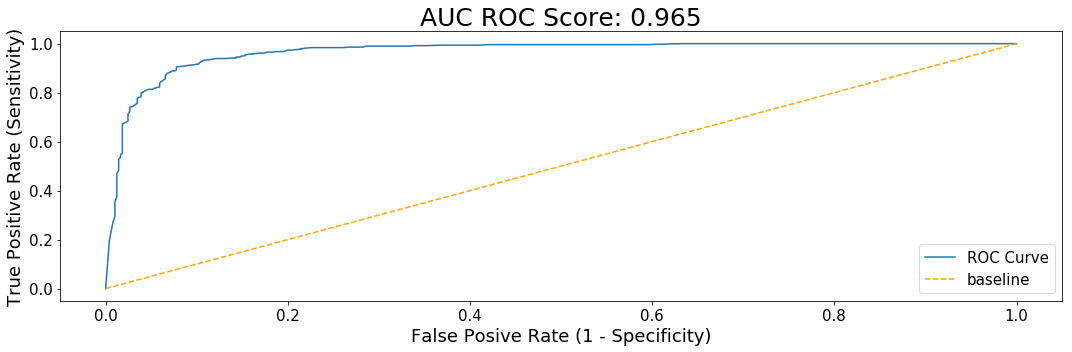

In [36]:
auc_roc_plot(cvec_gridsearch, X, y)

### Gett custom stopwords using 'best_stopwords()' function

In [37]:
cvec_gridsearch.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['about', '...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'cvec__max_df': [0.9, 0.95], 'cvec__min_df': [3, 5], 'cvec__ngram_range': [(1, 1), (2, 2)], 'lr__C': [1, 100000000000.0], 'lr__random_state': [42, 121]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
coef_df_005 = best_stopwords(cvec_gridsearch, X, y, n = 0.05 ,vect_str = 'cvec', reg_str = 'lr').copy()

In [39]:
stopwords_005 = list(coef_df_005.loc[coef_df_005['abs_perc_diff'] < 0.95 ].index)

In [40]:
len(stopwords_005)

319

In [41]:
coef_df_0025 = best_stopwords(cvec_gridsearch, X, y, n = 0.025 ,vect_str = 'cvec', reg_str = 'lr').copy()

In [42]:
stopwords_0025 = list(coef_df_0025.loc[coef_df_0025['abs_perc_diff'] < 0.95 ].index)

In [43]:
len(stopwords_0025)

182

In [44]:
coef_df_0005 = best_stopwords(cvec_gridsearch, X, y, n = 0.005 ,vect_str = 'cvec', reg_str = 'lr').copy()

In [45]:
stopwords_0005 = list(coef_df_0005.loc[coef_df_0005['abs_perc_diff'] < 0.95 ].index)

In [46]:
len(stopwords_0005)

56

In [47]:
coef_df_00025 = best_stopwords(cvec_gridsearch, X, y, n = 0.0025 ,vect_str = 'cvec', reg_str = 'lr').copy()

In [48]:
stopwords_00025 = list(coef_df_00025.loc[coef_df_00025['abs_perc_diff'] < 0.95 ].index)

In [49]:
len(stopwords_00025)

38

---
## Modeling

### CountVectorizer model

- **CountVectorizer** ('cvec')
    - Stopwords: 
        1. 'stopwords': built-in stop word
        2. 'stopwords' + ('stopwords_005', 'stopwords_0025', 'stopwords_0005', 'stopwords_00025')

    - preprosessor:
        1. PorterStemmer()
        2. WordNetLemmatizer()
        3. None

    - max_df:
        [0.85, 0.9, 0.95] 
        
    - min_df: 
        [5, 10, 15, 20] 
        
- **LogisticRegression** ('lr')
    - C:
       [1e-5, 1e-10, 1, 1e5 ,1e10],

In [50]:
# Make pipline for CountVectorizer + Logistic Regression model
cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())])

In [51]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [52]:
# Define dictionary of parameters.
cvec_params = {
    'cvec__stop_words': [stopwords, stopwords+stopwords_005 , stopwords+stopwords_0025,
                         stopwords+stopwords_0005, stopwords+stopwords_00025],
    'cvec__max_df': [0.85, 0.9, 0.95], # max_df: if the word shows up more than (0~1) of the posts(rows), ignore
    'cvec__min_df': [5, 10, 15, 20], # min_df: only consider the word shows up more than x posts (rows)
    'cvec__preprocessor': [stemmer.stem, lemmatizer.lemmatize],
    'lr__C': [1e-5, 1e-10, 1, 1e5 ,1e10]
}

In [53]:
# Instantiate our GridSearchCV object.
cvec_gridsearch = GridSearchCV(cvec_pipe, # What is the model we want to fit?
                               cvec_params, # What is the dictionary of hyperparameters?
                               cv=5) # What number of folds in CV will we use?

In [54]:
cvec_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'cvec__stop_words': [['about', 'cry', 'if', 'anywhere', 'own', 'via', 'mine', 'bottom', 'might', 'de', 'except', 'more', 'has', 'fifteen', 'three', 'co', 'became', 'seeming', 'thin', 'beforehand', 'keep', 'hereafter', 'and', 'sometime', 'that', 'some', 'few', 'twenty', 'ten', 'my', 'mill...tLemmatizer.lemmatize of <WordNetLemmatizer>>], 'lr__C': [1e-05, 1e-10, 1, 100000.0, 10000000000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

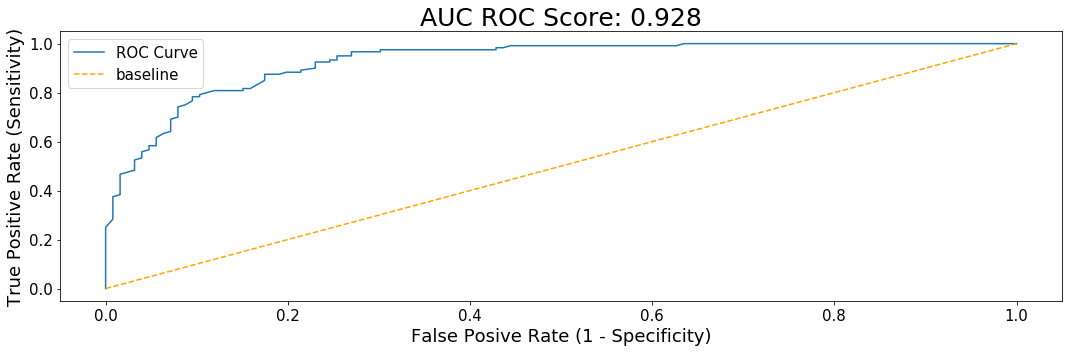

In [55]:
auc_roc_plot(cvec_gridsearch, X_test, y_test)

In [75]:
cvec_train_score = cvec_gridsearch.score(X_train, y_train)
cvec_test_score = cvec_gridsearch.score(X_test, y_test)
cvec_cv_score = cvec_gridsearch.best_score_
print("CountVectorizer model result:")
print(f"Train Score is {round(cvec_train_score,3)}")
print(f"Test Score is {round(cvec_test_score,3)}")
print(f"CV Score is {round(cvec_cv_score,3)}")

CountVectorizer model result:
Train Score is 0.947
Test Score is 0.832
CV Score is 0.834


In [58]:
# Checking which stopwords list were selected
len(cvec_gridsearch.best_params_['cvec__stop_words'])-len(stopwords)
# for cvec_gridsearch, 'stopwords_005' was selected

319

In [81]:
# Save list of words from the model and its coefficient as csv file
coef_df(cvec_gridsearch, X, y).sort_values('exp_coef', ascending=False)\
.to_csv('../data/model_data/coef_df_cvec.csv', index=False)

In [60]:
# Save list of words from the model and its freqency as csv file
best_stopwords(cvec_gridsearch, X, y, grab_all=True).to_csv('../data/model_data/all_stopwords_cvec.csv')

In [61]:
# Save result of CountVectorizer as csv file
feat_cvec = cvec_gridsearch.best_estimator_.named_steps['cvec'].transform(X).toarray()
feat_name_cvec = cvec_gridsearch.best_estimator_.named_steps['cvec'].get_feature_names()
feat_df_c = pd.DataFrame(feat_cvec, columns=feat_name_cvec)
pd.concat([feat_df_c,y], axis=1).to_csv('../data/model_data/cvec_df.csv', index=False)

### TfidfVectorizer model
- **TfidfVectorizer** ('tvec')
    - Stopwords: 
        1. 'stopwords': built-in stop word
        2. 'stopwords' + ('stopwords_005', 'stopwords_0025', 'stopwords_0005', 'stopwords_00025')

    - preprosessor (in Vectorizers)
        1. PorterStemmer()
        2. WordNetLemmatizer()
        3. None
    - max_df:
        [0.85, 0.9, 0.95] 
    - min_df': 
        [5, 10, 15, 20] 
             
- **LogisticRegression** ('lr')
    - C:
       [1e-5, 1e-10, 1, 1e5 ,1e10],

In [62]:
# Make pipline for TfidfVectorizer + Logistic Regression model

tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())])

In [63]:
# Define dictionary of parameters.
tvec_params = {
    'tvec__stop_words': [stopwords, stopwords+stopwords_005 , stopwords+stopwords_0025,
                         stopwords+stopwords_0005, stopwords+stopwords_00025],
    'tvec__max_df': [0.85, 0.9, 0.95], # max_df: if the word shows up more than (0~1) of the posts(rows), ignore
    'tvec__min_df': [5, 10, 15, 20], # min_df: only consider the word shows up more than x posts (rows)
    'tvec__preprocessor': [stemmer.stem, lemmatizer.lemmatize],
    'lr__C': [1e-5, 1e-10, 1, 1e5 ,1e10]
}

In [64]:
# Instantiate our GridSearchCV object.
tvec_gridsearch = GridSearchCV(tvec_pipe, # What is the model we want to fit?
                               tvec_params, # What is the dictionary of hyperparameters?
                               cv=5) # What number of folds in CV will we use?

In [65]:
tvec_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tvec__stop_words': [['about', 'cry', 'if', 'anywhere', 'own', 'via', 'mine', 'bottom', 'might', 'de', 'except', 'more', 'has', 'fifteen', 'three', 'co', 'became', 'seeming', 'thin', 'beforehand', 'keep', 'hereafter', 'and', 'sometime', 'that', 'some', 'few', 'twenty', 'ten', 'my', 'mill...tLemmatizer.lemmatize of <WordNetLemmatizer>>], 'lr__C': [1e-05, 1e-10, 1, 100000.0, 10000000000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

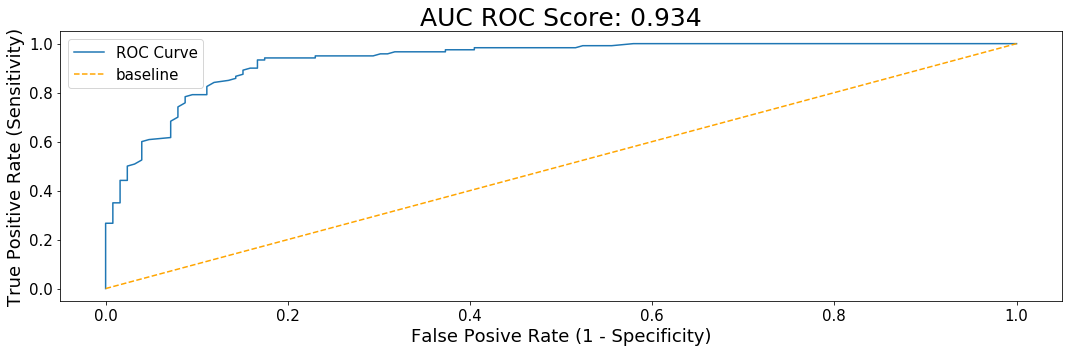

In [66]:
auc_roc_plot(tvec_gridsearch, X_test, y_test)

In [74]:
tvec_train_score = tvec_gridsearch.score(X_train, y_train)
tvec_test_score = tvec_gridsearch.score(X_test, y_test)
tvec_cv_score = tvec_gridsearch.best_score_
print("Tf-Idf Vectorizer model result:")
print(f"Train Score is {round(tvec_train_score,3)}")
print(f"Test Score is {round(tvec_test_score,3)}")
print(f"CV Score is {round(tvec_cv_score,3)}")

Tf-Idf Vectorizer model result:
Train Score is 0.902
Test Score is 0.841
CV Score is 0.838


In [69]:
# Checking which stopwords list were selected

len(tvec_gridsearch.best_params_['tvec__stop_words'])-len(stopwords)
# for tvec_gridsearch, 'stopwords_0025' was selected

319

In [83]:
# Save list of words from the model and its coefficient as csv file

coef_df(tvec_gridsearch, X, y, vect_str='tvec').sort_values('exp_coef', ascending=False)\
.to_csv('../data/model_data/coef_df_tvec.csv', index=False)

In [71]:
# Save list of words from the model and its freqency as csv file

best_stopwords(tvec_gridsearch, X, y, grab_all=True, vect_str='tvec').to_csv('../data/model_data/all_stopwords_tvec.csv')

## best_stopwords function's result on Tfidf Vectorizer model is not accurate

In [72]:
# Save result of TfidfVectorizer as csv file

feat_tvec = tvec_gridsearch.best_estimator_.named_steps['tvec'].transform(X).toarray()
feat_name_tvec = tvec_gridsearch.best_estimator_.named_steps['tvec'].get_feature_names()
feat_df_t = pd.DataFrame(feat_tvec, columns=feat_name_tvec)
pd.concat([feat_df_t,y], axis=1).to_csv('../data/model_data/tvec_df.csv', index=False)

-----
# Observations

|               | Count Vectorizer & Logistic model | Tf - Idf Vectorizer & Logistic model |
|---------------|-----------------------|--------------------------|
| Train Score   | 0.947                 | 0.902                    |
| Test Score    | 0.832                 | 0.841                    |
| CV Score      | 0.834                 | 0.837                    |
| AUC ROC score | 0.928                 | 0.934                    |

** Tf-Idf Vectorizer model works better**
    - Tf-Idf Vectorizer model scored higher on Test, CV and AUC ROC score than Count Vectorizer model.
    - Although Count Vectorizer model has higher train score, it appears to be more overfit than Tf-Idf model.